### a more direct estimation of I/E balance during ripples by checking the proportion of spikes from pyr and from int per event.

In [1]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

import nelpy as nel
import nelpy.plotting as npl
from nelpy import core

import itertools
from scipy import stats

import warnings

import multiprocessing
from joblib import Parallel, delayed

import glob
import seaborn as sns

import math



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## load data frames and set up paths

In [2]:
project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'      

save_path = 'F:/Projects/PAE_PlaceCell/analysis/i_e_balance/'
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes'

## main analysis

In [3]:
# nelpy gets mad if we are using different time res to index
# for our purpose here, this is okay
warnings.filterwarnings('ignore')

def load_add_spikes(spike_path,session,fs=32000):
    spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
    spikes_ = list(itertools.chain(*spikes))
    session_bounds = nel.EpochArray([min(spikes_), max(spikes_)])
    return nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=fs)

def get_binned_vec(st,temp_df,cell_type,area,ds=0.025,sigma=0.015):
    
    # pull out specific units (type of unit (pyr vs. int), brain area, >= 100 spikes)
    idx = np.where((temp_df.cell_type == cell_type) &
                   (temp_df.area == area) &
                   (temp_df.n_spikes >= 100))[0]+1
    
    # check if no units exist with the above condition
    if len(idx) == 0:
        return np.nan
    
    # bin spikes times
    temp_binned = st._unit_subset(idx).bin(ds=ds)
    # sum binned vector and smooth
    vector = nel.AnalogSignalArray(np.sum(temp_binned.data,axis=0),
                                timestamps=temp_binned.bin_centers,
                                   fs=1/ds).smooth(sigma=sigma)
    
    # zscore entire session reduce bias if there are more units in a cell type
    vector.data[0] = stats.zscore(vector.data[0])
    
    return vector

def run_all(session,data_path,spike_path,df_swr,df_cell_class,ds=0.025):
    
    # find current session in cell df
    temp_df_cell_class = df_cell_class[df_cell_class.session == session]
    
    # load spike times from all units
    st_all = load_add_spikes(spike_path,session)
    
    # set up empty variables to fill below
    pyr_mean=[]
    int_mean=[]
    e_i_diff=[]
    n_pyr=[]
    n_int=[]
    area=[]
    session_=[]
    rat=[]
    group=[]
    pyr_data=[]
    int_data=[]
    pyr_peak=[]
    int_peak=[]
    peak_delay=[]
    e_i_ratio=[]
    e_i_peak_diff=[]
    e_i_peak_ratio=[]
    
    for area_ in temp_df_cell_class.area.unique():
        # bin and smooth activity from pyr and int
        pyr_vec = get_binned_vec(st_all,temp_df_cell_class,'pyr',area_,ds=ds)
        int_vec = get_binned_vec(st_all,temp_df_cell_class,'int',area_,ds=ds)
        
        # find number of units
        n_pyr_ = sum((temp_df_cell_class.cell_type == 'pyr') &
                     (temp_df_cell_class.area == area_) &
                     (temp_df_cell_class.n_spikes >= 100))
        
        n_int_ = sum((temp_df_cell_class.cell_type == 'int') &
                     (temp_df_cell_class.area == area_) &
                     (temp_df_cell_class.n_spikes >= 100))
        
        # maybe there are no pyr or int units
        if ((isinstance(int_vec, core.AnalogSignalArray)==False) | 
            (isinstance(pyr_vec, core.AnalogSignalArray)==False)):
            continue

        # find current session and current area in swr df
        # here we are only comparing spiking during ripples from the same area
        temp_df_swr = df_swr[(df_swr.session == session) & (df_swr.area == area_)]
                
        # loop through each ripple and assess the contribution of pyr and int units
        for event in temp_df_swr.itertuples():
            
            # create epoch object to index below vector
            ep = nel.EpochArray([event.start_time, event.end_time])

            # pull out ripple epoch and compare vectors
            pyr_mean.append(pyr_vec[ep].data[0].mean())
            int_mean.append(int_vec[ep].data[0].mean())
            
            # mean difference
            e_i_diff.append(pyr_mean[-1] - int_mean[-1])
            
            # mean ratio
            e_i_ratio.append(pyr_mean[-1] / int_mean[-1])

            # peak magnitude
            pyr_peak.append(pyr_vec[ep].data[0].max())
            int_peak.append(int_vec[ep].data[0].max())
            
            # peak diff
            e_i_peak_diff.append(pyr_peak[-1] - int_peak[-1])
            
            # peak ratio
            e_i_peak_ratio.append(pyr_peak[-1] / int_peak[-1])

            # pyr to int peak time delay
            peak_delay.append(
                (np.argmax(pyr_vec[ep].data[0]) - 
                 np.argmax(int_vec[ep].data[0])) * ds 
            )
            
            # num of units
            n_pyr.append(n_pyr_)
            n_int.append(n_int_)

            # collect ID
            area.append(area_)
            session_.append(session)
            rat.append(event.rat)
            group.append(event.group)
            
            # collect vectors
            pyr_data.append(pyr_vec[ep].data[0])
            int_data.append(int_vec[ep].data[0])
            
            
    df = pd.DataFrame()        
    # package data
    df['session'] = session_
    df['rat'] = rat
    df['group'] = group
    df['area'] = area
    df['pyr_mean'] = pyr_mean
    df['int_mean'] = int_mean
    df['e_i_diff'] = e_i_diff
    df['e_i_ratio'] = e_i_ratio
    df['pyr_peak'] = pyr_peak
    df['int_peak'] = int_peak
    df['e_i_peak_diff'] = e_i_peak_diff
    df['e_i_peak_ratio'] = e_i_peak_ratio
    df['peak_delay'] = peak_delay
    df['n_pyr'] = n_pyr
    df['n_int'] = n_int
    
    results = {}
    results['df'] = df
    results['pyr_data'] = pyr_data
    results['int_data'] = int_data

    return results

## section to handle runing through all sessions

In [4]:
def main_loop(session,data_path,spike_path,save_path,df_swr,df_cell_class):
    '''
    main_loop: file management 
    '''
    
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
        
    # calc some features
    results = run_all(session,data_path,spike_path,df_swr,df_cell_class)
    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

def i_e_balance_run(data_path,spike_path,save_path,df_swr,df_cell_class,parallel=True):
    """
    function to loop through each session
    you can use a basic loop or run in parallel
    """

    # find sessions to run
    sessions = pd.unique(df_swr.session)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,
                                                                       data_path,
                                                                       spike_path,
                                                                       save_path,
                                                                       df_swr,
                                                                       df_cell_class
                                                                       ) for session in sessions)
    else:    
        for session in sessions:
            print(session)
            main_loop(session,data_path,spike_path,save_path,df_swr,df_cell_class)

## test single session

In [59]:
session = 'LEM3216_S20190814123043'
results = run_all(session,data_path,spike_path,df_swr,df_cell_class,ds=0.01)


In [ ]:
sns.pairplot(results['df'],corner=True)


-0.02

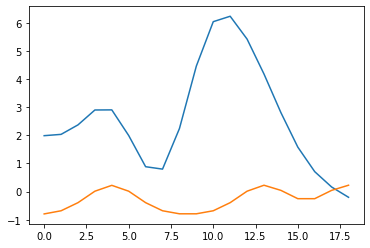

In [51]:
plt.plot(results['pyr_data'][2])
plt.plot(results['int_data'][2])

(np.argmax(results['pyr_data'][2]) - np.argmax(results['int_data'][2])) * 0.01

## Run all sessions

In [125]:
%%time

i_e_balance_run(data_path,spike_path,save_path,df_swr,df_cell_class,parallel=True)


Wall time: 3min 8s


## load results into single data frame

In [5]:
def load_in_everything(save_path):
    df = []
    pyr_data=[]
    int_data=[]
    sessions = glob.glob(save_path + '*.pkl')
    for session in sessions:
        with open(session, 'rb') as f:
            results = pickle.load(f)

        df.append(results['df'])  
        pyr_data.append(results['pyr_data'])    
        int_data.append(results['int_data'])    

    return pd.concat(df),pyr_data,int_data

df,pyr_data,int_data = load_in_everything(save_path)
# df

In [6]:
## remove non HPC
df = df[(df.area == 'ca1') | (df.area == 'ca3')]
df

,session,rat,group,area,pyr_mean,int_mean,e_i_diff,e_i_ratio,pyr_peak,int_peak,e_i_peak_diff,e_i_peak_ratio,peak_delay,n_pyr,n_int
0,LEM3116_S20180715121821,LEM3116,control,ca1,-0.022353,-1.058872,1.036519,0.021110,0.816914,-1.058872,1.875786,-0.771495,0.050,18.0,7.0
1,LEM3116_S20180715121821,LEM3116,control,ca1,0.528171,-0.627661,1.155833,-0.841491,4.796014,1.619956,3.176058,2.960583,-0.150,18.0,7.0
2,LEM3116_S20180715121821,LEM3116,control,ca1,0.864472,-0.355251,1.219723,-2.433416,4.139441,1.810455,2.328986,2.286409,0.025,18.0,7.0
3,LEM3116_S20180715121821,LEM3116,control,ca1,0.110170,-0.707487,0.817658,-0.155721,0.948644,0.469077,0.479566,2.022361,0.000,18.0,7.0
4,LEM3116_S20180715121821,LEM3116,control,ca1,0.556974,-0.339203,0.896177,-1.642006,2.273409,0.662530,1.610880,3.431408,0.075,18.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,RH16_S20161126145021,RH16,pae,ca1,0.119327,2.016997,-1.897671,0.059160,0.863459,3.800060,-2.936601,0.227223,-0.025,5.0,13.0
0,RH16_S20161126150318,RH16,pae,ca1,-0.955459,0.602102,-1.557561,-1.586871,-0.483795,1.477245,-1.961040,-0.327498,0.025,10.0,12.0
1,RH16_S20161126150318,RH16,pae,ca1,1.279397,0.889620,0.389777,1.438139,2.702520,2.887662,-0.185142,0.935885,0.025,10.0,12.0
2,RH16_S20161126150318,RH16,pae,ca1,-0.450711,0.033413,-0.484125,-13.488945,-0.319232,1.542693,-1.861926,-0.206932,-0.050,10.0,12.0


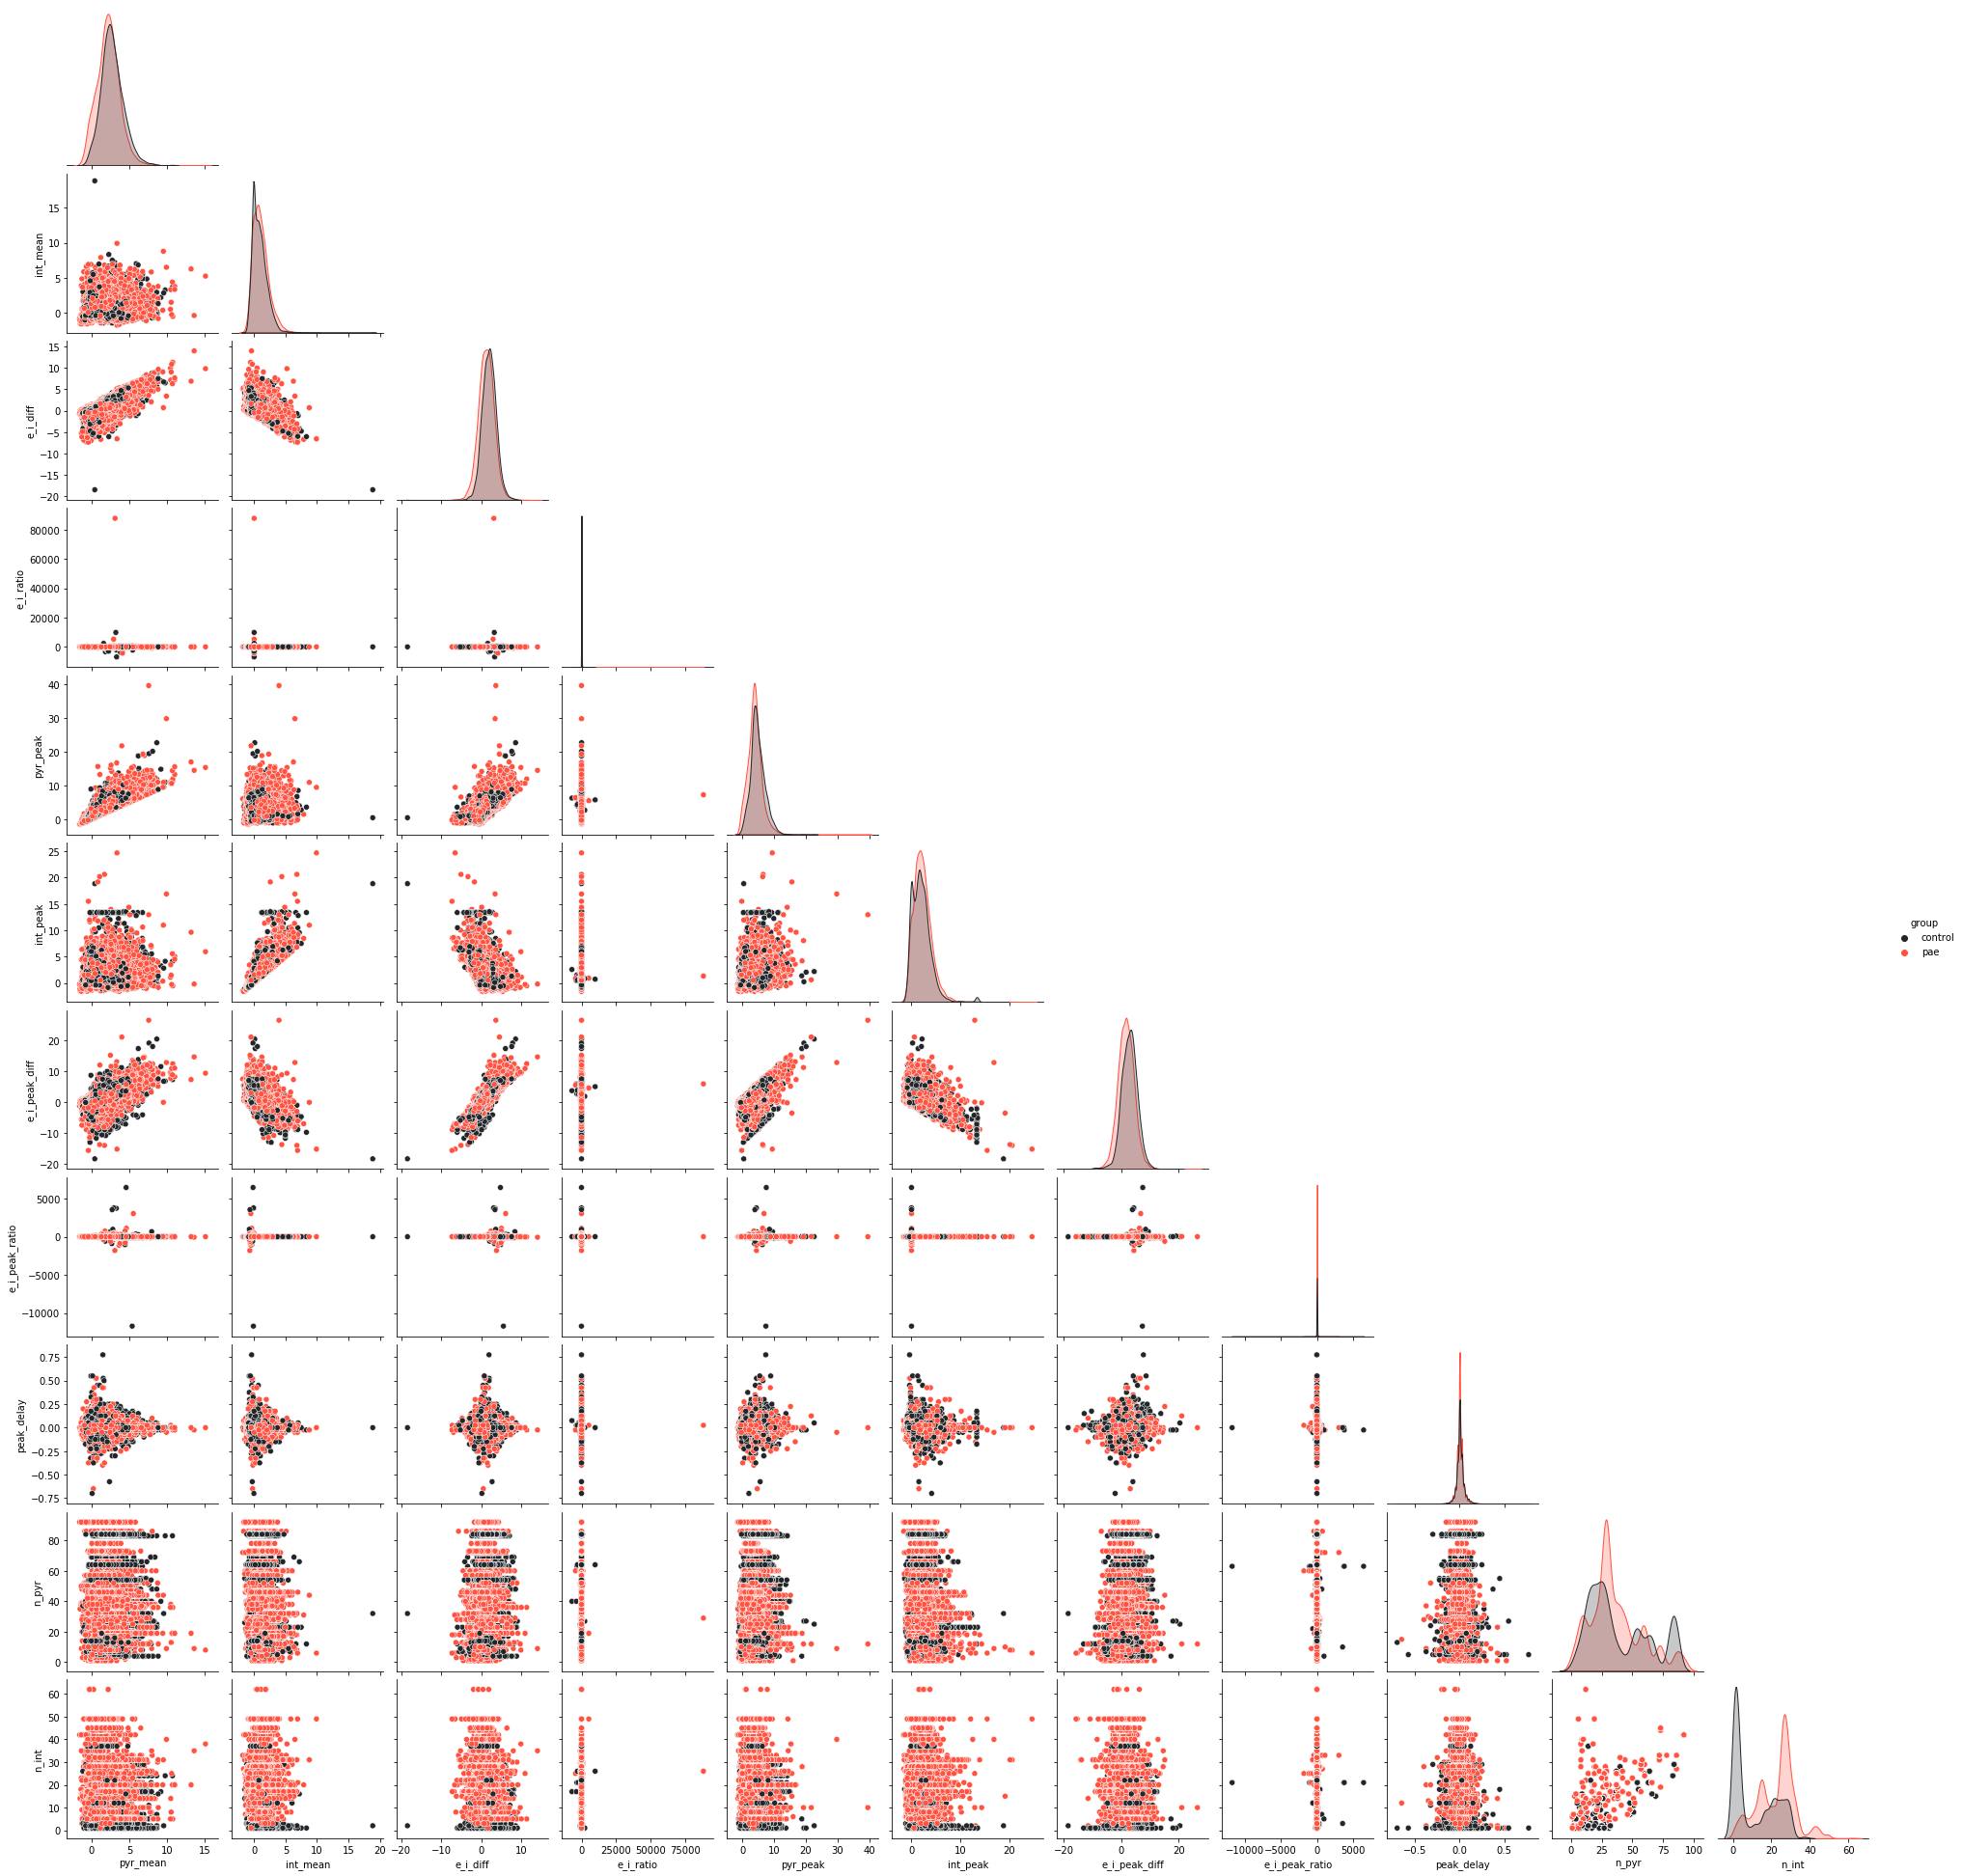

In [128]:
sns.pairplot(df,hue="group",corner=True)


## save data frame for stats in R

In [129]:
df.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\i_e_balance\post_processed\e_i_df.csv')

In [7]:
group_colors = {"controlca1": '#222629ff',
                "controlca3": '#103876ff',
                'paeca1': '#ff5240ff',
                'paeca3': '#ebad46ff'} 
def ecdf(x):
    xs = np.sort(x)
    ys = np.linspace(0,1,len(xs))
    return xs, ys


def plot_ecdf(var,df,area,ax,group_colors):
    for rat in pd.unique(df.rat):
        y = df[(df.rat == rat) & (df.area == area)]
        if y.empty == False:
            xs, ys = ecdf(y[var])
            ax.plot(xs,ys,color=group_colors[y.group.iloc[0]+y.area.iloc[0]],linewidth=.5)

def make_x_same_range(axs,ax_num):
    axs[ax_num[0]].set_xlim(min(axs[ax_num[0]].get_xlim()[0],axs[ax_num[1]].get_xlim()[0]),
                            max(axs[ax_num[0]].get_xlim()[1],axs[ax_num[1]].get_xlim()[1]))
    axs[ax_num[1]].set_xlim(min(axs[ax_num[0]].get_xlim()[0],axs[ax_num[0]].get_xlim()[0]),
                            max(axs[ax_num[0]].get_xlim()[1],axs[ax_num[1]].get_xlim()[1]))
    

tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'    

In [8]:
fig_save_path = r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment'


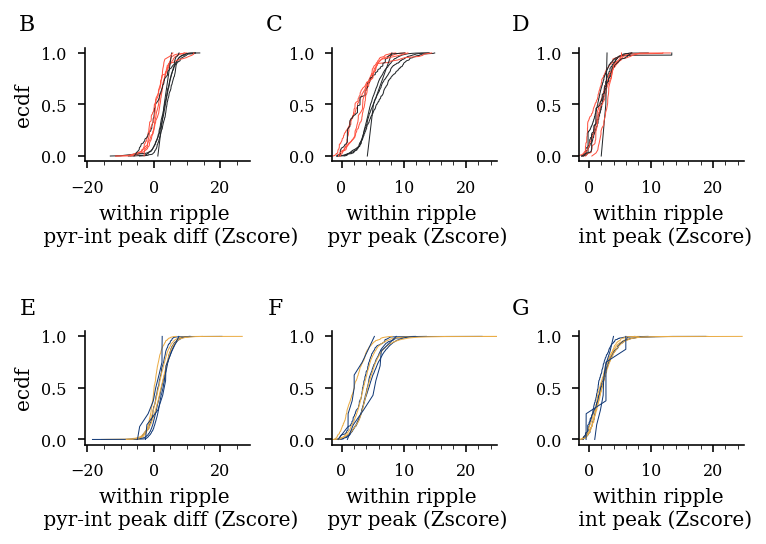

In [160]:
from matplotlib.ticker import AutoMinorLocator

fig, axs = plt.subplots(2,3, figsize=set_size('thesis', fraction=1, subplots=(1,1)), edgecolor='k')
fig.subplots_adjust(hspace = 1.5, wspace=0.5)
axs = axs.ravel()

ax_num = [0,3]
plot_ecdf('e_i_peak_diff',df,'ca1',axs[ax_num[0]],group_colors)
plot_ecdf('e_i_peak_diff',df,'ca3',axs[ax_num[1]],group_colors)
make_x_same_range(axs,ax_num)

ax_num = [1,4]
plot_ecdf('pyr_peak',df,'ca1',axs[ax_num[0]],group_colors)
plot_ecdf('pyr_peak',df,'ca3',axs[ax_num[1]],group_colors)
# make_x_same_range(axs,ax_num)

ax_num = [2,5]
plot_ecdf('int_peak',df,'ca1',axs[ax_num[0]],group_colors)
plot_ecdf('int_peak',df,'ca3',axs[ax_num[1]],group_colors)
# make_x_same_range(axs,ax_num)

axs[1].set_xlim(df.pyr_peak.min(),25)
axs[2].set_xlim(df.pyr_peak.min(),25)
axs[4].set_xlim(df.pyr_peak.min(),25)
axs[5].set_xlim(df.pyr_peak.min(),25)

axs[0].set_ylabel('ecdf')
axs[3].set_ylabel('ecdf')


axs[0].set_xlabel('within ripple \n pyr-int peak diff (Zscore)')
axs[3].set_xlabel('within ripple \n pyr-int peak diff (Zscore)')

axs[1].set_xlabel('within ripple \n pyr peak (Zscore)')
axs[4].set_xlabel('within ripple \n pyr peak (Zscore)')

axs[2].set_xlabel('within ripple \n int peak (Zscore)')
axs[5].set_xlabel('within ripple \n int peak (Zscore)')



for i in range(6):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    
for i, label in enumerate(('B', 'C', 'D','E','F','G')):
    axs[i].text(-0.3, 1.3, label, transform=axs[i].transAxes,
      fontsize=11, fontweight='normal', va='top', ha='right')
    
plt.savefig(os.path.join(fig_save_path,'i_e_features.svg'),dpi=300,bbox_inches='tight')  
    

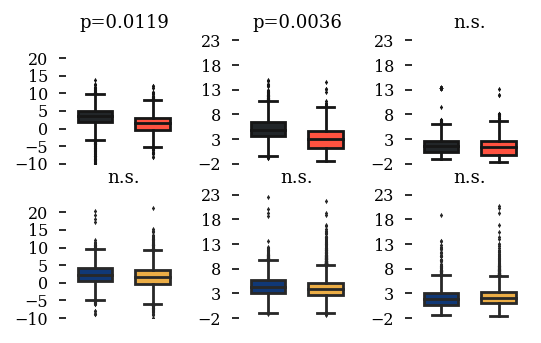

In [10]:

fig, axs = plt.subplots(2,3, figsize=set_size('thesis', fraction=.7, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0.25, wspace=.5)
axs = axs.ravel()


sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="e_i_peak_diff", data=df[(df.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="e_i_peak_diff", data=df[(df.area=='ca3')],
            width=.6,ax=axs[3],saturation=1,fliersize=.5)
axs[3].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="pyr_peak", data=df[(df.area=='ca1')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="pyr_peak", data=df[(df.area=='ca3')],
            width=.6,ax=axs[4],saturation=1,fliersize=.5)
axs[4].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="int_peak", data=df[(df.area=='ca1')],
            width=.6,ax=axs[2],saturation=1,fliersize=.5)
axs[2].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="int_peak", data=df[(df.area=='ca3')],
            width=.6,ax=axs[5],saturation=1,fliersize=.5)
axs[5].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.despine(trim=True, left=True, bottom=True)

axs[0].set_ylim(-9,25)
axs[3].set_ylim(-9,25)

axs[0].set_yticks(np.arange(-10, 25, 5))
axs[3].set_yticks(np.arange(-10, 25, 5))


axs[1].set_ylim(df.pyr_peak.min(),20)
axs[2].set_ylim(df.pyr_peak.min(),20)
axs[4].set_ylim(df.pyr_peak.min(),20)
axs[5].set_ylim(df.pyr_peak.min(),20)

axs[1].set_yticks(np.arange(math.floor(df.pyr_peak.min()), 25, 5))
axs[2].set_yticks(np.arange(math.floor(df.pyr_peak.min()), 25, 5))
axs[4].set_yticks(np.arange(math.floor(df.pyr_peak.min()), 25, 5))
axs[5].set_yticks(np.arange(math.floor(df.pyr_peak.min()), 25, 5))


axs[0].set_title('p=0.0119',fontsize=9)
axs[1].set_title('p=0.0036',fontsize=9)
axs[2].set_title('n.s.',fontsize=9)
axs[3].set_title('n.s.',fontsize=9)
axs[4].set_title('n.s.',fontsize=9)
axs[5].set_title('n.s.',fontsize=9)

plt.savefig(os.path.join(fig_save_path,'i_e_features_box.svg'),dpi=300,bbox_inches='tight')  


# make example plot of analysis

In [156]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def plot_e_i_example(st_all,temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts,rip_n,bounds=.2):
    
    fig, axs = plt.subplots(4,1, figsize=set_size('thesis', fraction=1, subplots=(1, 1)),gridspec_kw={'height_ratios': [1,1,1,3]})
    fig.subplots_adjust(hspace = 0, wspace=.5)
    axs = axs.ravel()   

    # get color for cell types
    colors = []
    for item in temp_df_cell_class.cell_type:
        if item=="pyr": 
            colors.append('#08F7FE')
        else:
            colors.append('#FE53BB')
            
    start = temp_df_swr.start_time.iloc[rip_n]-bounds
    end = temp_df_swr.end_time.iloc[rip_n]+bounds

    ep = nel.EpochArray([start, end])
    
    # current lfp
    current_lfp = lfp[(lfp_ts > start) & (lfp_ts < end),temp_df_swr.peak_channel.iloc[rip_n]]
    current_lfp_ts = lfp_ts[(lfp_ts > start) & (lfp_ts < end)]
    axs[0].plot(current_lfp_ts,current_lfp,color='k',linewidth=1)
    
    x = np.linspace(start, end, len(pyr_vec[ep].data[0]))
    axs[1].plot(x,pyr_vec[ep].data[0],color='#08F7FE',label='pyr activity')
    # axs[0].axvspan(temp_df_swr.start_time.iloc[5], temp_df_swr.end_time.iloc[5], alpha=0.2, color='#843b62', zorder=-1000)

    axs[2].plot(x,int_vec[ep].data[0],color='#FE53BB',label='int activity')
    # axs[1].axvspan(temp_df_swr.start_time.iloc[5], temp_df_swr.end_time.iloc[5], alpha=0.2, color='#843b62', zorder=-1000)

    axs[3].eventplot(st_all[ep].data,color=colors,linewidths=2,linelengths=2)
    # axs[2].axvspan(temp_df_swr.start_time.iloc[5], temp_df_swr.end_time.iloc[5], alpha=0.2, color='#843b62', zorder=-1000)

    axs[3].set_ylim(-.1,st_all[ep].data.shape[0])
    axs[3].set_yticks([0,st_all[ep].data.shape[0]])


    for event in temp_df_swr[(temp_df_swr.peak_time > start) & (temp_df_swr.peak_time < end)].itertuples():
        axs[0].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
        axs[1].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
        axs[2].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
        axs[3].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)


    axs[1].set_ylim(np.hstack([int_vec[ep].data[0],pyr_vec[ep].data[0]]).min()-.5,
                    np.hstack([int_vec[ep].data[0],pyr_vec[ep].data[0]]).max()+.5)
    axs[2].set_ylim(np.hstack([int_vec[ep].data[0],pyr_vec[ep].data[0]]).min()-.5,
                    np.hstack([int_vec[ep].data[0],pyr_vec[ep].data[0]]).max()+.5)

    axs[0].set_xlim(start,end)
    axs[1].set_xlim(start,end)
    axs[2].set_xlim(start,end)
    axs[3].set_xlim(start,end)

    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[2].spines['bottom'].set_visible(False)

    axs[0].axes.get_xaxis().set_ticks([])
    axs[1].axes.get_xaxis().set_ticks([])
    axs[2].axes.get_xaxis().set_ticks([])

    axs[0].axes.get_yaxis().set_ticks([])
    axs[2].axes.get_yaxis().set_ticks([])
    axs[0].spines['left'].set_visible(False)
    axs[2].spines['left'].set_visible(False)

    for i in range(4):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)

    axs[1].set_ylabel('activity \n (Zscore)')

    axs[3].set_ylabel('neurons')
    axs[3].set_xlabel('time (sec)')

    axs[1].legend(frameon=False,loc='upper right')
    axs[2].legend(frameon=False,loc='upper right')
    
    return axs
    
def load_data_for_plot(spike_path,session):
    
    st_all = load_add_spikes(spike_path,session)
    temp_df_cell_class = df_cell_class[df_cell_class.session == session]
    temp_df_swr = df_swr[df_swr.session == session]

    pyr_vec = get_binned_vec(st_all,temp_df_cell_class,'pyr','ca1',ds=0.01)
    int_vec = get_binned_vec(st_all,temp_df_cell_class,'int','ca1',ds=0.01)


    path = get_session_path('F:/Projects/PAE_PlaceCell/ProcessedData/'+session+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    lfp,lfp_ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs)

    return st_all,temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts    

## PAE CA1

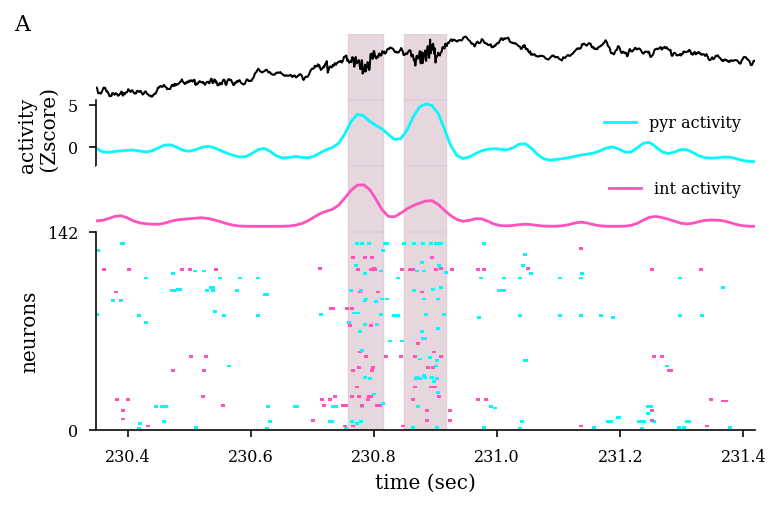

In [159]:
st_all,temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts = load_data_for_plot(spike_path,'LEM3124_S20190302163218')

axs = plot_e_i_example(st_all,temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts,16,bounds=.5)

axs[0].text(-0.1, 1.3, 'A', transform=axs[0].transAxes, fontsize=11, fontweight='normal', va='top', ha='right')

ids = temp_df_swr.group.iloc[0]+temp_df_swr.area.iloc[0]+temp_df_swr.session.iloc[0]
plt.savefig(os.path.join(fig_save_path,ids+'i_e_example.svg'),dpi=300,bbox_inches='tight')  


In [ ]:
temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts = load_data_for_plot(spike_path,'LEM3216_S20190718101925')

for i in range(len(temp_df_swr)):
    plot_e_i_example(temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts,i,bounds=.5)
    plt.savefig(os.path.join(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\i_e_examples',str(i)+'_i_e_example.png'),dpi=300,bbox_inches='tight')  


In [ ]:

temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts = load_data_for_plot(spike_path,'LEM3216_S20190718101925')

plot_e_i_example(temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts,16,bounds=.5)

ids = temp_df_swr.group.iloc[0]+temp_df_swr.area.iloc[0]+temp_df_swr.session.iloc[0]
plt.savefig(os.path.join(fig_save_path,ids+'i_e_example.svg'),dpi=300,bbox_inches='tight')  


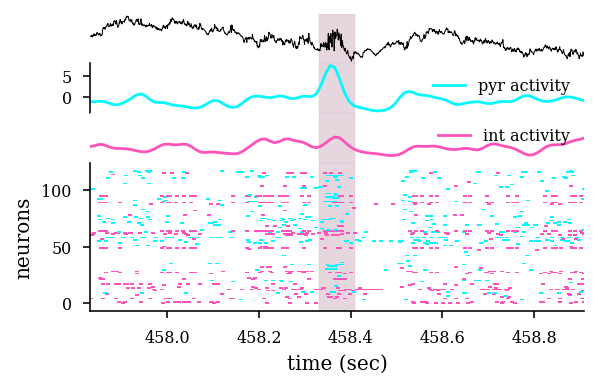

In [112]:
plot_e_i_example(temp_df_swr,temp_df_cell_class,pyr_vec,int_vec,lfp,lfp_ts,20,bounds=.5)
plt.savefig(os.path.join(fig_save_path,'i_e_example.svg'),dpi=300,bbox_inches='tight')  


In [168]:


def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'pae'
    return df


# F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed
# df_cell_class.rat
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\pyr_int_df.csv')

df_cell_class = add_group_affiliation(df_cell_class)

rat = [s.split('_')[0] for s in df_cell_class.session]
df_cell_class['rat']=rat



# # df_cell_class
df_cell_class.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\pyr_int_df.csv')


In [169]:
df_cell_class

,Unnamed: 0,Unnamed: 0.1,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,...,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type,area,rat,group
0,0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,...,0.021529,1.149097,1.535871,2.529014,3.181064,7340,pyr,ca1,LEM3116,control
1,1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,...,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr,ca1,LEM3116,control
2,2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,...,0.041928,1.235779,1.773778,2.580697,3.908416,7490,pyr,ca1,LEM3116,control
3,3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,...,0.000555,1.032228,0.999013,0.621228,3.730098,1803,pyr,ca1,LEM3116,control
4,4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,...,0.011062,0.983793,1.406165,2.959360,3.743105,8589,pyr,ca1,LEM3116,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,8777,8777,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,3.311529,...,0.000000,1.059228,5.973929,0.789008,4.629547,1252,pyr,ca1,RH16,pae
8778,8778,8778,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,12.260592,...,0.004489,0.735687,23.134516,13.056442,2.818769,20718,int,ca1,RH16,pae
8779,8779,8779,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,3.685590,...,0.000000,0.955257,6.281825,0.626417,21.188431,994,int,ca1,RH16,pae
8780,8780,8780,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,9.395189,...,0.021382,0.999326,31.814075,1.533272,2.350860,2433,pyr,ca1,RH16,pae
